In [1]:
# Standard library imports
from argparse import ArgumentParser
import os, sys
THIS_DIR = os.path.abspath('')
PARENT_DIR = os.path.dirname(os.path.abspath(''))
sys.path.append(PARENT_DIR)

# Third party imports
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from torchdiffeq import odeint
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np

# local application imports
from lag_caVAE.lag import Lag_Net
from lag_caVAE.nn_models import MLP_Encoder, MLP, MLP_Decoder, PSD
from hyperspherical_vae.distributions import VonMisesFisher
from hyperspherical_vae.distributions import HypersphericalUniform
from utils import arrange_data, from_pickle, my_collate, ImageDataset
from examples.acro_lag_cavae_trainer import Model as Model_lag_cavae
from ablations.ablation_acro_MLPdyna_cavae_trainer import Model as Model_MLPdyna_cavae
from ablations.ablation_acro_lag_vae_trainer import Model as Model_lag_vae
from ablations.ablation_acro_lag_MLPEnc_caDec_trainer import Model as Model_lag_MLPEnc_caDec
from ablations.ablation_acro_lag_caEnc_MLPDec_trainer import Model as Model_lag_caEnc_MLPDec
from ablations.ablation_acro_lag_caAE_trainer import Model as Model_lag_caAE
from ablations.HGN import Model as Model_HGN

seed_everything(0)
%matplotlib inline
DPI = 600

# https://stackoverflow.com/questions/53472940/nameerror-name-base-is-not-defined-openai-gym
import pyvirtualdisplay

_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

In [2]:
# homo_u, bs 256, annealing
checkpoint_path = os.path.join(PARENT_DIR, 
                               'checkpoints', 
                               'updated-acro-lag-cavae-T_p=4-epoch=998.ckpt')
model_lag_cavae = Model_lag_cavae.load_from_checkpoint(checkpoint_path)

checkpoint_path = os.path.join(PARENT_DIR, 
                               'checkpoints', 
                               'ablation-acro-MLPdyna-cavae-T_p=4-epoch=998.ckpt')
model_MLPdyna_cavae = Model_MLPdyna_cavae.load_from_checkpoint(checkpoint_path)

checkpoint_path = os.path.join(PARENT_DIR, 
                               'checkpoints', 
                               'ablation-acro-lag-vae-T_p=4-epoch=996.ckpt')
model_lag_vae = Model_lag_vae.load_from_checkpoint(checkpoint_path)

# This model is trained with learning rate 1e-4
checkpoint_path = os.path.join(PARENT_DIR, 
                               'checkpoints', 
                               'ablation-acro-lag-MLPEnc-caDec-T_p=4-epoch=988.ckpt')
model_lag_MLPEnc_caDec = Model_lag_MLPEnc_caDec.load_from_checkpoint(checkpoint_path)

# This model is trained with learning rate 1e-4
checkpoint_path = os.path.join(PARENT_DIR, 
                               'checkpoints', 
                               'ablation-acro-lag-caEnc-MLPDec-T_p=4-epoch=674.ckpt')
model_lag_caEnc_MLPDec = Model_lag_caEnc_MLPDec.load_from_checkpoint(checkpoint_path)

checkpoint_path = os.path.join(PARENT_DIR, 
                               'checkpoints', 
                               'ablation-acro-lag-caAE-T_p=4-epoch=963.ckpt')
model_lag_caAE = Model_lag_caAE.load_from_checkpoint(checkpoint_path)

# This model is trained with learning rate 1e-4
checkpoint_path = os.path.join(PARENT_DIR, 
                               'checkpoints', 
                               'baseline-acro-HGN-T_p=4-epoch=1759.ckpt')
model_HGN = Model_HGN.load_from_checkpoint(checkpoint_path)

In [3]:
# Load data, prepare for plotting prediction
data_path=os.path.join(PARENT_DIR, 'datasets', 'acrobot-gym-image-dataset-rgb-u9-test.pkl')
test_dataset = ImageDataset(data_path, 19, ctrl=False)
# select a particular trajectory
batch_idx = 21

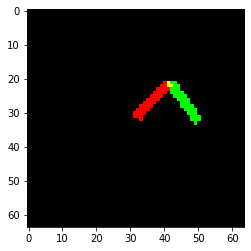

In [4]:
# plot initial configuration
plt.imshow(np.moveaxis(test_dataset.x[0,batch_idx], 0, 2))

In [5]:
test_dataset.x.shape

(20, 256, 3, 64, 64)

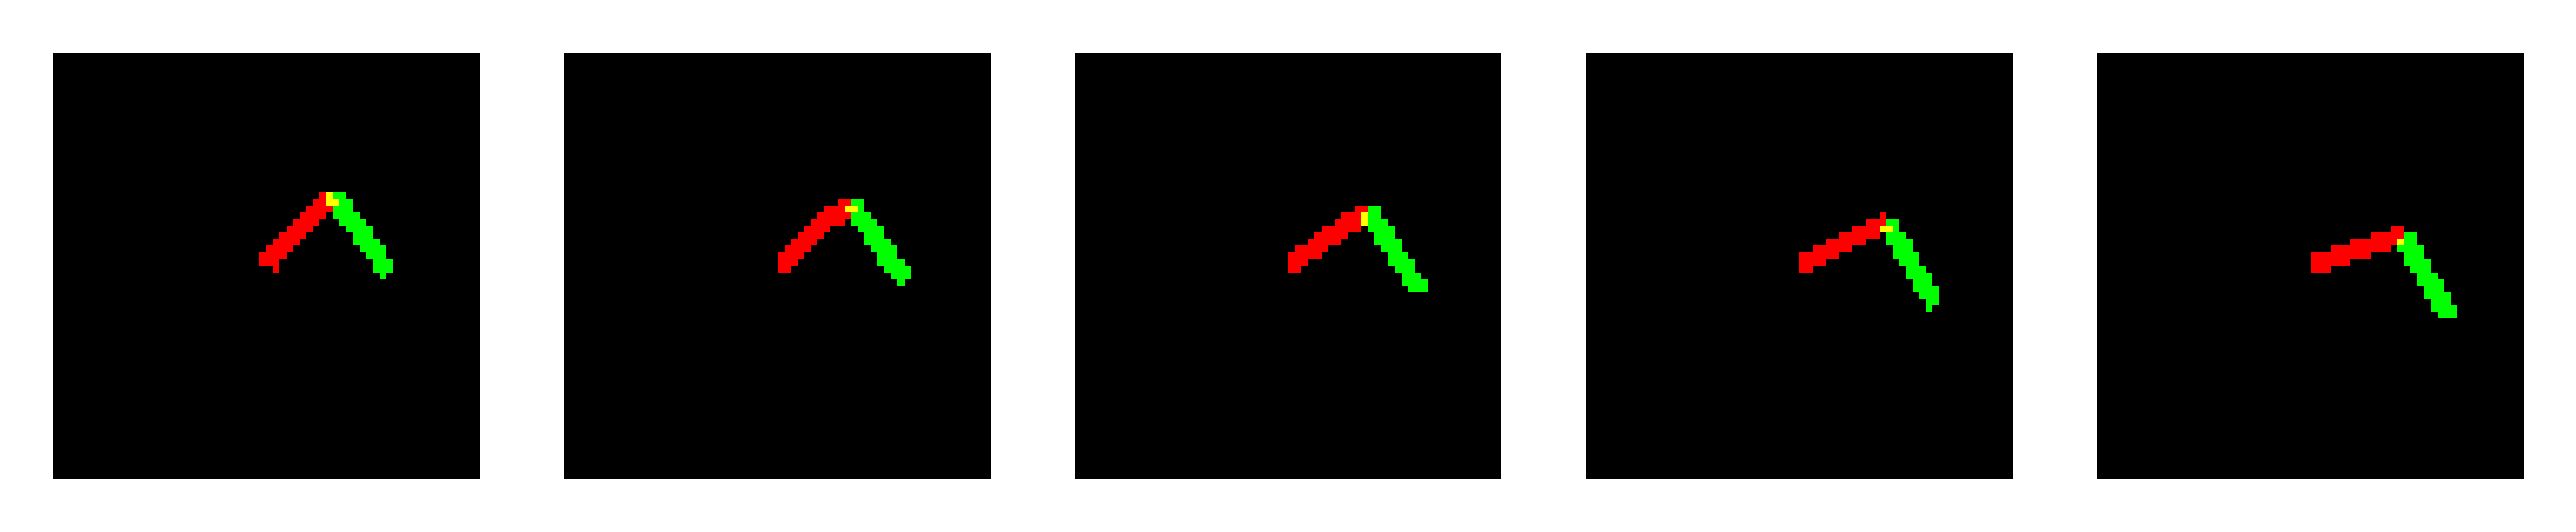

In [6]:
# plot true sequence
fig = plt.figure(figsize=(16, 4), dpi=DPI)
for i in range(5):
    plt.subplot(1, 13, i+1)
    plt.imshow(np.moveaxis(test_dataset.x[i, batch_idx], 0, 2))
    plt.axis('off')
# fig.savefig(os.path.join(PARENT_DIR, 'figures', f'true_acro_seq'), bbox_inches='tight')

In [7]:
X = torch.tensor(test_dataset.x[0:2, batch_idx], dtype=torch.float32).view(2, 1, 3, 64, 64)
u = torch.tensor([0.0, 0.0], dtype=torch.float32).view(1,2)

timesteps = 5
t_eval = np.linspace(0, timesteps-1, timesteps) * 0.05
t_eval = torch.tensor(t_eval, dtype=torch.float32)

In [8]:
def plot_prediction(model, name, solver='rk4'):
    model.t_eval = t_eval
    model.hparams.solver = solver
    model(X, u)
    print(name)
    fig = plt.figure(figsize=(16, 4), dpi=DPI)
    for i in range(5):
        plt.subplot(1, 13, i+1)
        plt.imshow(model.Xrec[i, 0].permute(1,2,0).detach().cpu().numpy())
        plt.axis('off')
#     fig.savefig(os.path.join(PARENT_DIR, 'figures', f'prediction_acro_{name}'), bbox_inches='tight')

/home/z0042y5x/.pyenv/versions/3.7.5/envs/lag/lib/python3.7/site-packages/torch/nn/functional.py:3447: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/z0042y5x/.pyenv/versions/3.7.5/envs/lag/lib/python3.7/site-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0

lag_cavae


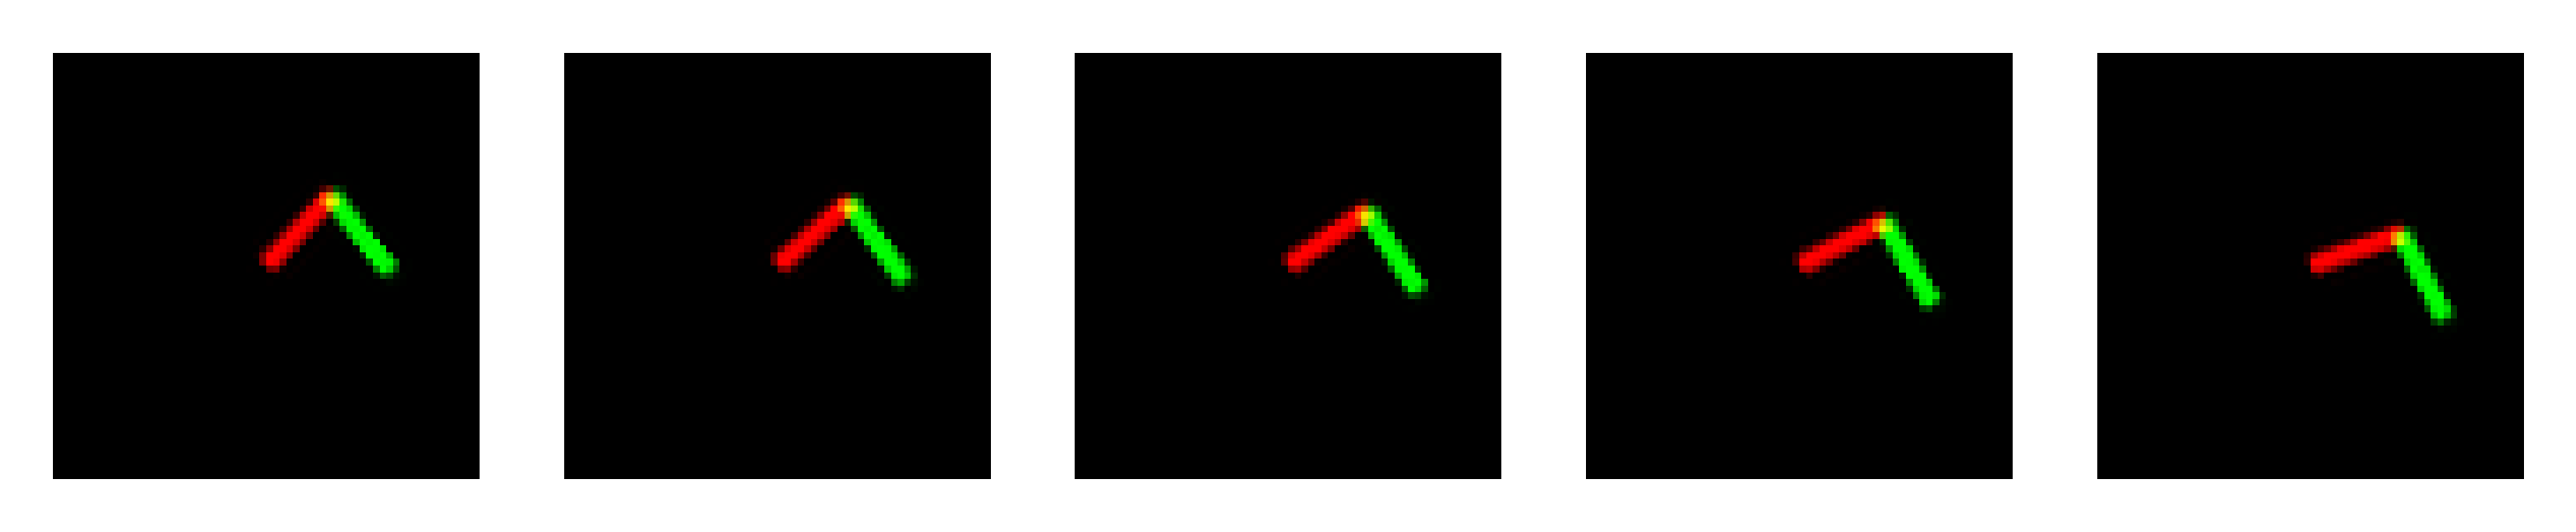

In [9]:
plot_prediction(model_lag_cavae, 'lag_cavae')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MLPdyna_cavae


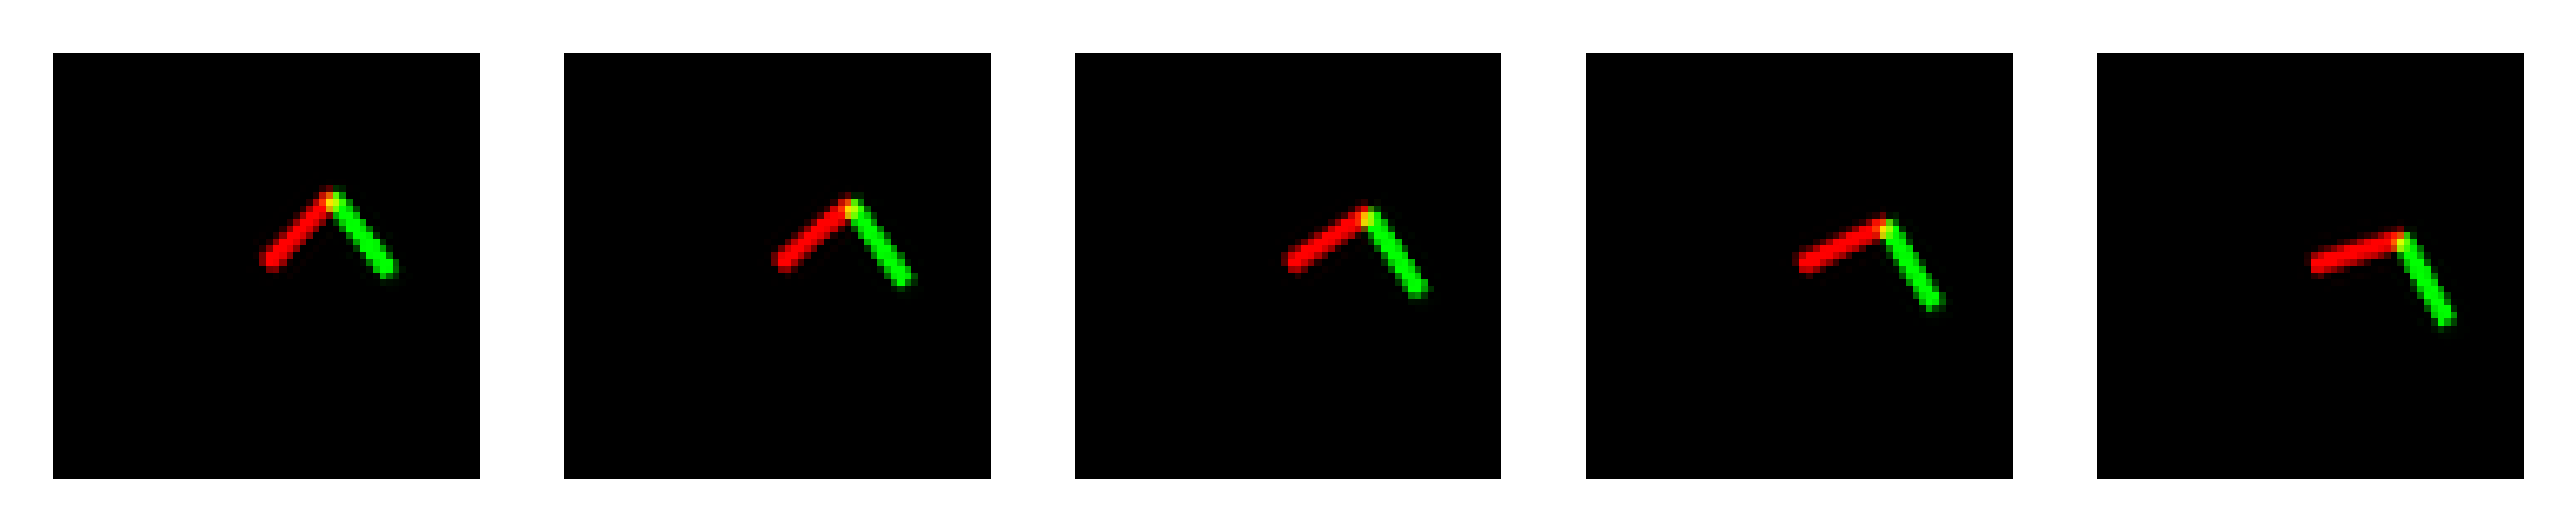

In [10]:
plot_prediction(model_MLPdyna_cavae, 'MLPdyna_cavae')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lag_caAE


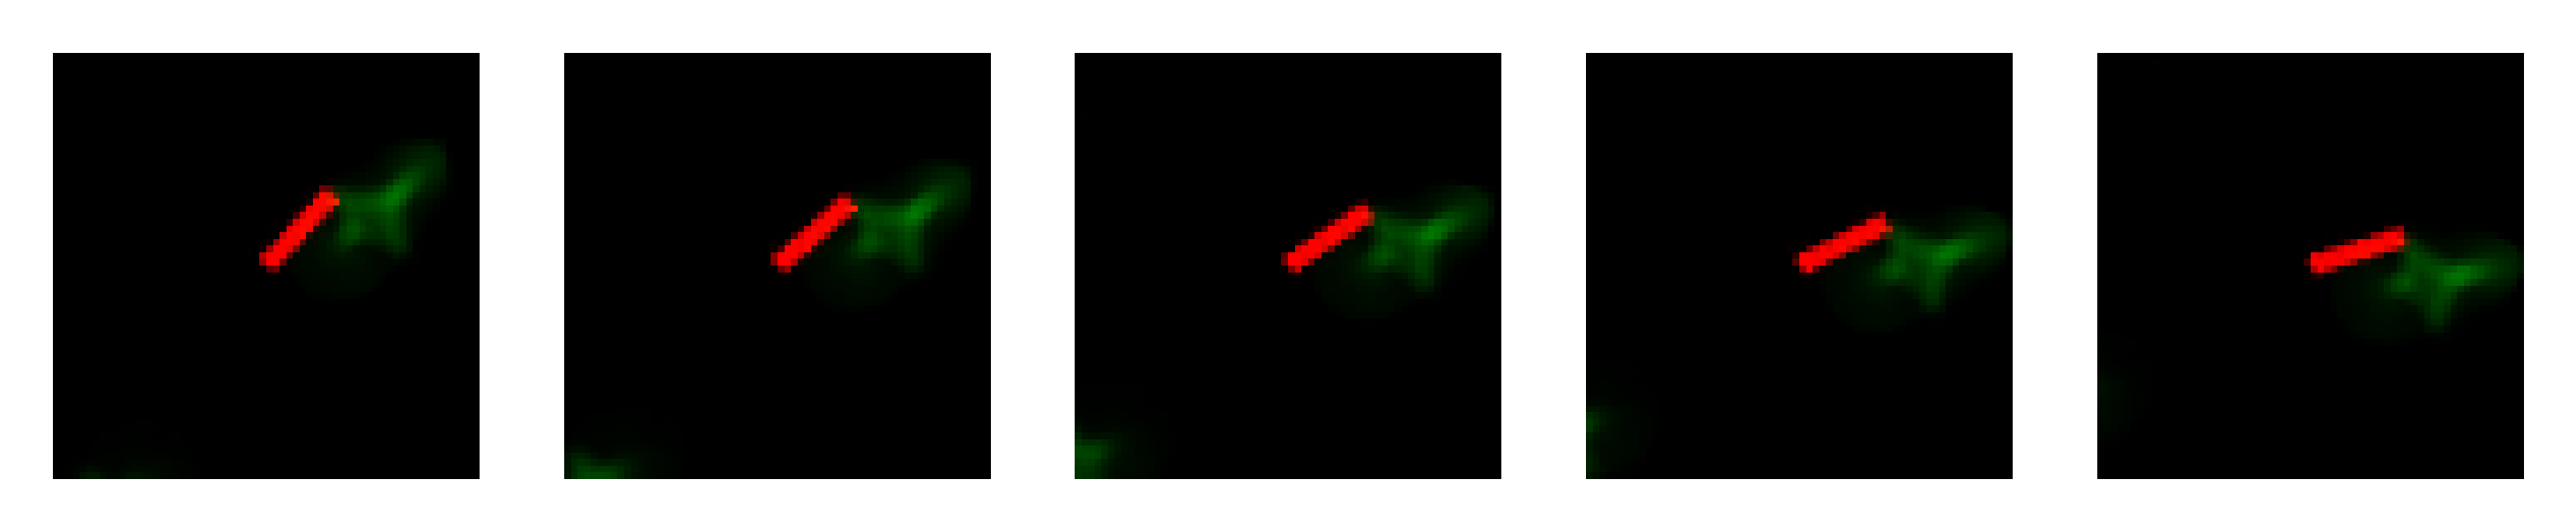

In [11]:
plot_prediction(model_lag_caAE, 'lag_caAE')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lag_caEnc_MLPDec


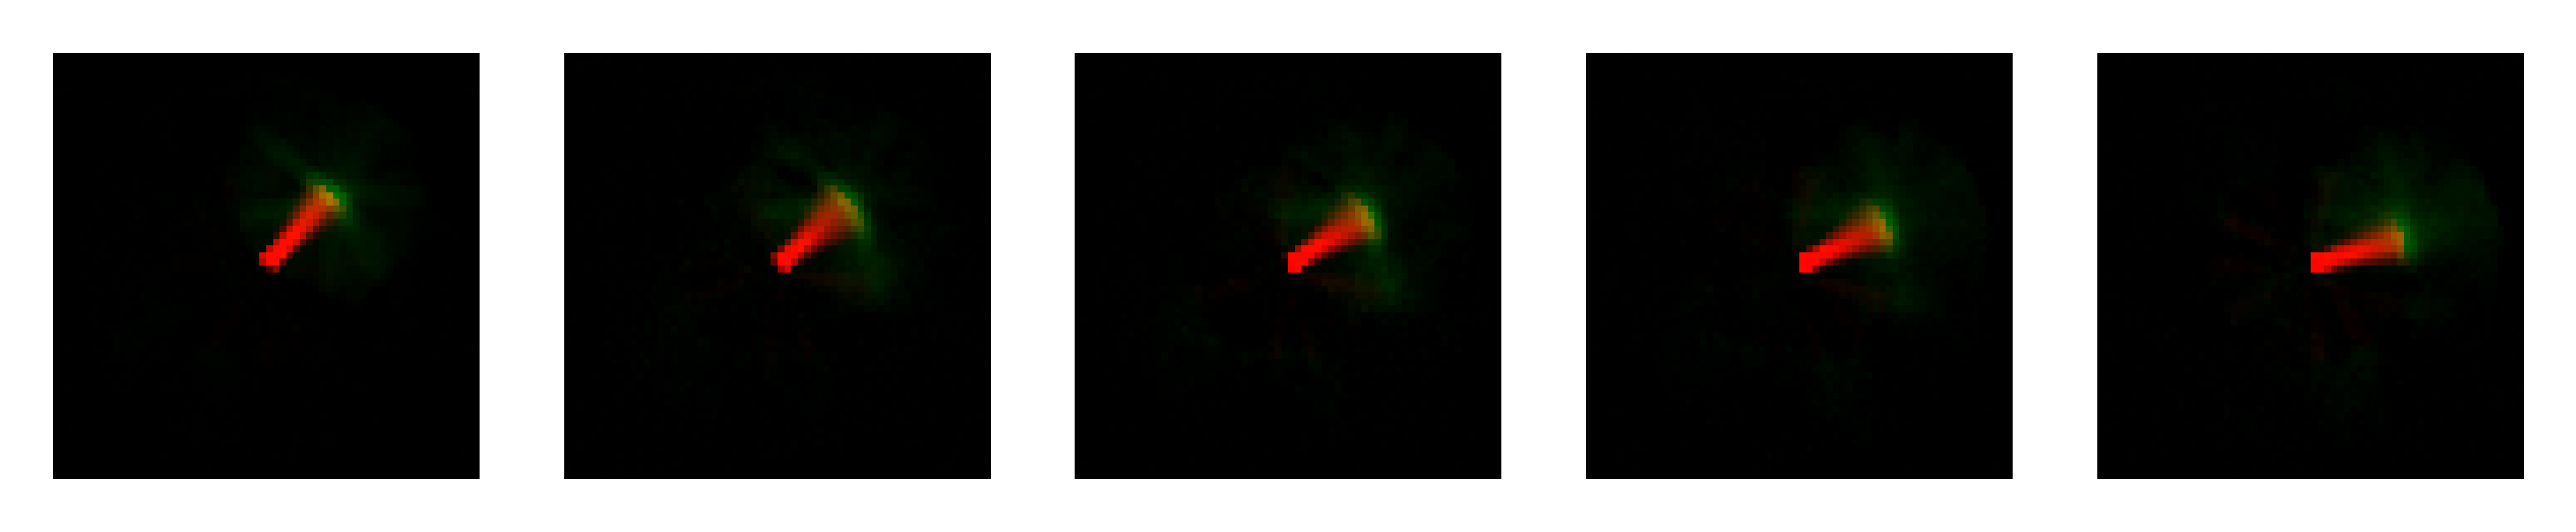

In [12]:
plot_prediction(model_lag_caEnc_MLPDec, 'lag_caEnc_MLPDec')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lag_MLPEnc_caDec


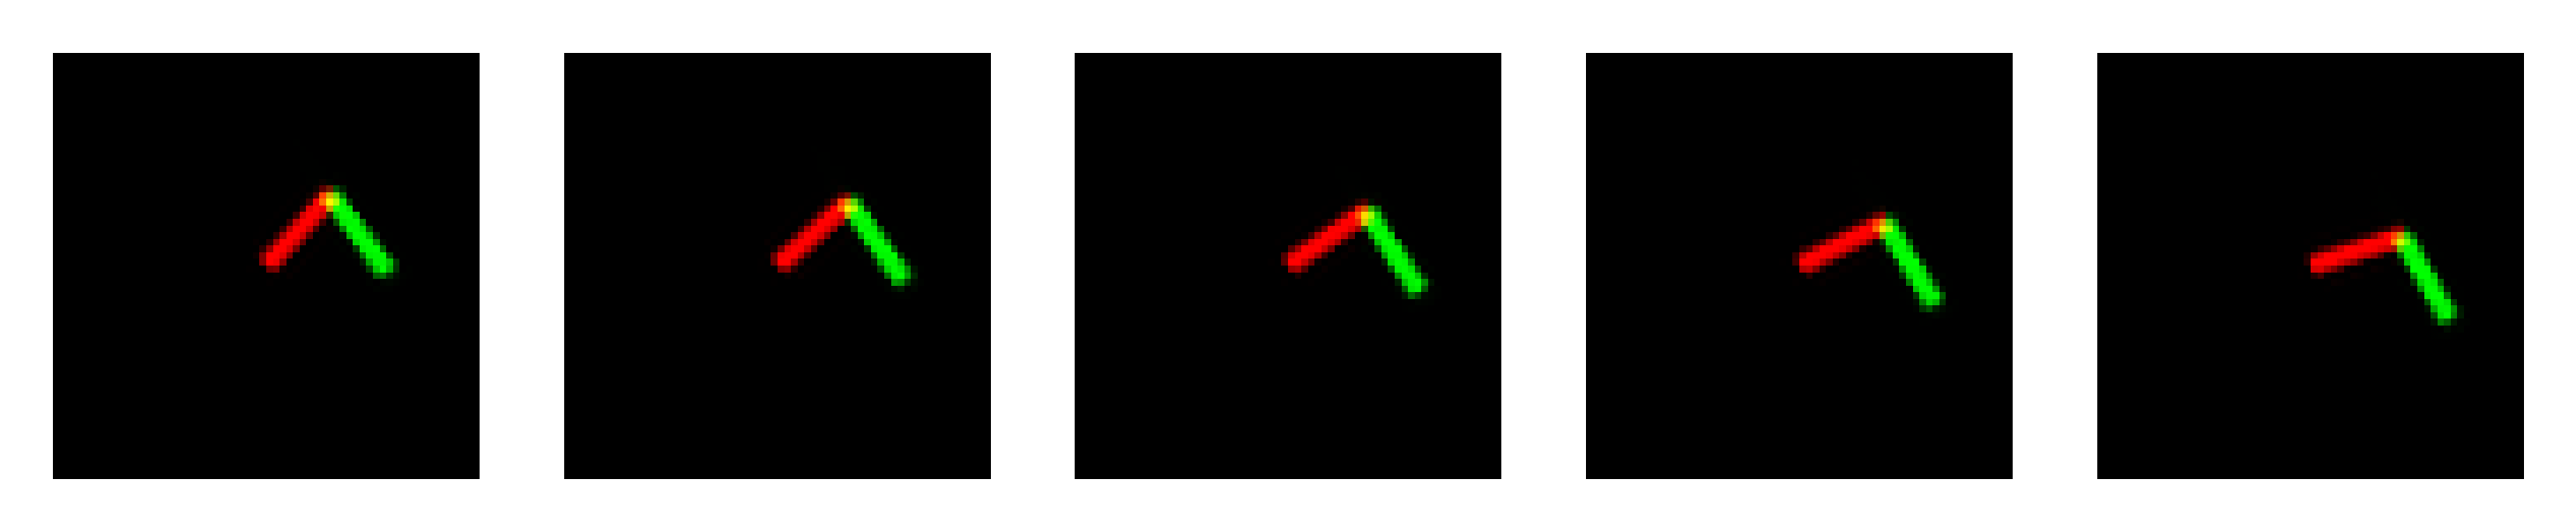

In [13]:
plot_prediction(model_lag_MLPEnc_caDec, 'lag_MLPEnc_caDec')

In [14]:
X = torch.tensor(test_dataset.x[0:5, 21], dtype=torch.float32).view(5, 1, 3, 64, 64)
[T, bs, c, _, _] = X[0:5].shape
X_0_5 = F.interpolate(X[0:5].view(T*bs, c, 64, 64), size=[32, 32]).view(T, bs, c, 32, 32)

HGN


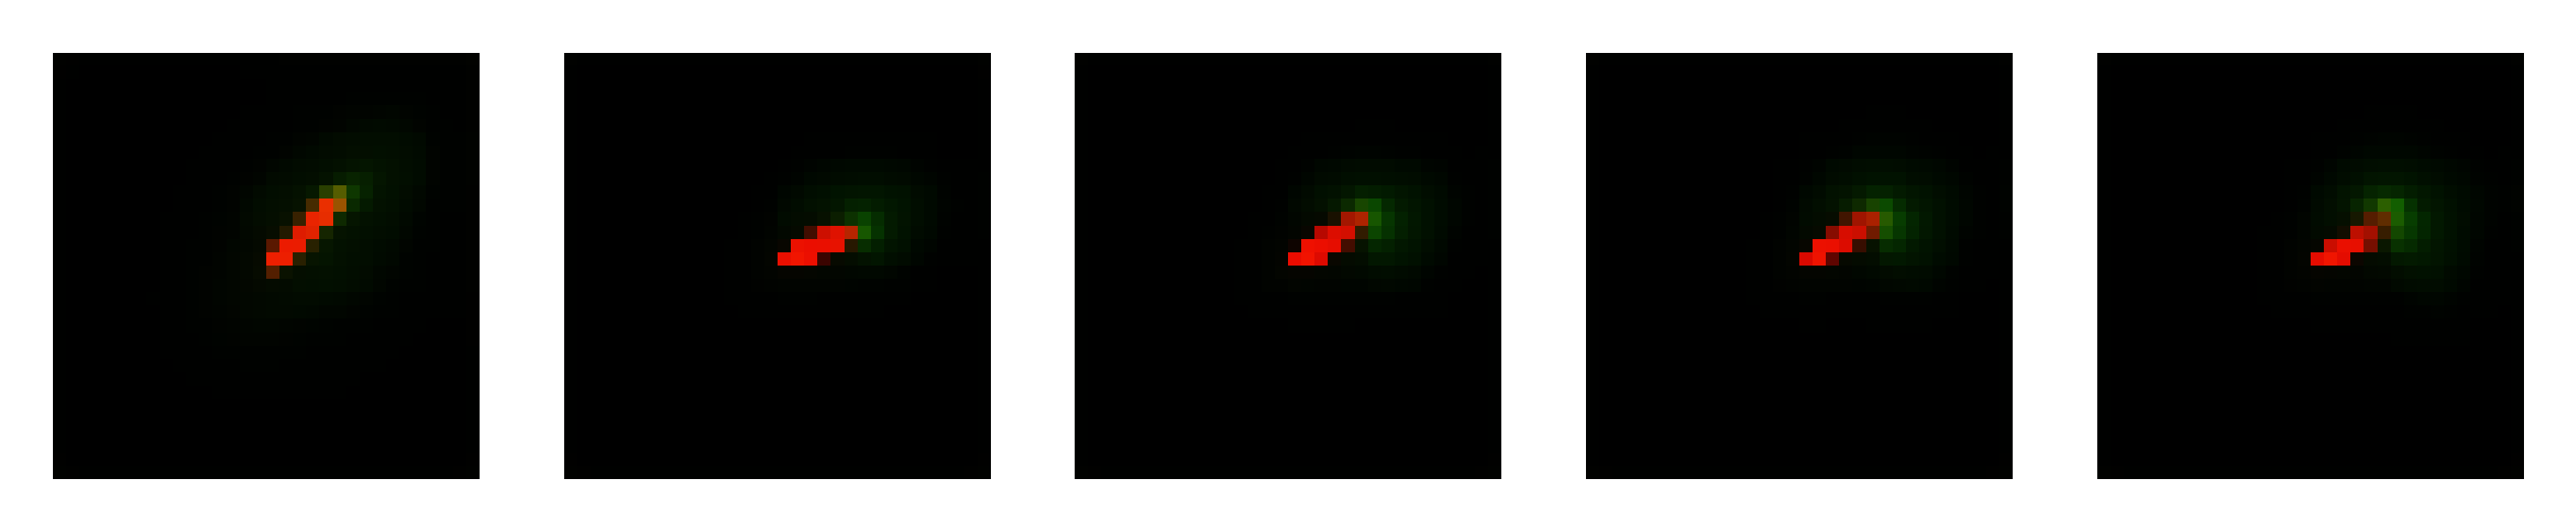

In [15]:
model = model_HGN ; solver = 'rk4' ; name = 'HGN'
model.t_eval = t_eval
model.hparams.solver = solver
model.step = 3 ; model.alpha = 1
model(X_0_5)
print(name)
fig = plt.figure(figsize=(16, 4), dpi=DPI)
for i in range(5):
    plt.subplot(1, 13, i+1)
    plt.imshow(model.Xrec[i, 0].permute(1,2,0).detach().cpu().numpy())
    plt.axis('off')
# fig.savefig(os.path.join(PARENT_DIR, 'figures', f'prediction_acro_{name}'), bbox_inches='tight')